# PART 2- MACHINE LEARNING

## מגישים:
### Nitzan Avraham- 207400284
### Adir Ohel Cohen- 207603929

#### על מנת לקבל דיוק במודל מומלץ להוסיף API KEY לפונקציה get_distance_from_center

In [4]:
import requests
import json
import re
import pandas as pd
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import mean_squared_error, make_scorer

In [5]:
df = pd.read_csv('train.csv')  # הקפד שהקובץ נמצא בתיקייה של הקוד
display(df.head())

print(f"\nמספר שורות (דירות): {df.shape[0]}")
print(f"מספר עמודות (מאפיינים): {df.shape[1]}")

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,price,num_of_images,distance_from_center
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,10150.0,6.0,1005.0
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,6600.0,3.0,253.0
2,דירה,הצפון הישן החלק המרכזי,וורמיזה 5,2.5,1,65,NaN,NaN,12.0,400.0,...,1,1,0,0,1,0,1,9000.0,8.0,740.0
3,דירה,הצפון הישן החלק המרכזי,עמנואל הרומי 30,2.0,3,40,NaN,0.0,12.0,100.0,...,0,0,0,0,0,0,0,5800.0,2.0,1206.0
4,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 50,3.0,1,70,NaN,0.0,11.0,250.0,...,1,0,1,0,0,0,1,7700.0,5.0,255.0



מספר שורות (דירות): 788
מספר עמודות (מאפיינים): 26


In [6]:
# בדיקת סוגי העמודות — חשוב כדי לדעת אילו עמודות צריך להמיר או לקודד
print("\nסוגי עמודות (dtypes):")
print(df.dtypes)


סוגי עמודות (dtypes):
property_type            object
neighborhood             object
address                  object
room_num                float64
floor                    object
area                      int64
garden_area             float64
days_to_enter           float64
num_of_payments         float64
monthly_arnona          float64
building_tax            float64
total_floors            float64
description              object
has_parking               int64
has_storage               int64
elevator                  int64
ac                        int64
handicap                  int64
has_bars                  int64
has_safe_room             int64
has_balcony               int64
is_furnished              int64
is_renovated              int64
price                   float64
num_of_images           float64
distance_from_center    float64
dtype: object


In [7]:
print("\nכמות ערכים חסרים בכל עמודה:")
print(df.isnull().sum())

# בדיקת ערכים ייחודיים לעמודות קטגוריות עיקריות — חשוב לראות אם יש ערכים חריגים או שגיאות כתיב
categorical_cols = ['property_type', 'neighborhood']
for col in categorical_cols:
    if col in df.columns:
        print(f"\nערכים ייחודיים בעמודה '{col}':")
        print(df[col].unique())



כמות ערכים חסרים בכל עמודה:
property_type             2
neighborhood              4
address                  30
room_num                  0
floor                     5
area                      0
garden_area             126
days_to_enter           180
num_of_payments           7
monthly_arnona          160
building_tax            132
total_floors             45
description               5
has_parking               0
has_storage               0
elevator                  0
ac                        0
handicap                  0
has_bars                  0
has_safe_room             0
has_balcony               0
is_furnished              0
is_renovated              0
price                     2
num_of_images             1
distance_from_center     19
dtype: int64

ערכים ייחודיים בעמודה 'property_type':
['דירה' 'דירת גן' 'דופלקס' 'יחידת דיור' 'גג/פנטהאוז' 'כללי'
 'באתר מופיע ערך שלא ברשימה הסגורה' 'גג/ פנטהאוז' 'דו משפחתי'
 'גג/פנטהאוז להשכרה' 'החלפת דירות' 'סטודיו/לופט' 'דירה להשכרה' 'חניה

### פונקציות לפילטור וסינון הדאטה

In [9]:
def extract_street(address):
    """
    מחלץ את שם הרחוב מתוך כתובת, למשל:
    'לאונרדו דה וינצי 14' -> 'לאונרדו דה וינצי'
    """
    if pd.isnull(address):
        return None
    match = re.match(r'^(.+?)(?:\s+\d+.*)?$', str(address).strip())
    return match.group(1).strip() if match else address

def process_floors(df):
    """
    פונקציה זו:
    1. מפצלת ערכים כמו '8 מתוך 10' ל־floor=8, total_floors=10.
    2. מטפלת ב'קרקע', ערכים עשרוניים, ערכים חריגים (למשל 810 במקום 8 מתוך 10).
    3. מעתיקה floor ל-total_floors אם total_floors חסר ויש floor.
    4. ממלאת חסרים לפי חציון ברחוב (ולא כתובת מלאה!).
    """

    # --- שלב 1: פיצול floor ו-total_floors מתוך מחרוזות ---
    floors = []
    totals = []
    for val in df['floor'].astype(str):
        if "מתוך" in val:
            parts = val.split("מתוך")
            floor_part = parts[0].strip()
            total_part = parts[1].strip()
            floor_val = 0 if "קרקע" in floor_part else int(float(floor_part)) if floor_part.replace('.', '', 1).isdigit() else np.nan
            total_val = 0 if "קרקע" in total_part else int(float(total_part)) if total_part.replace('.', '', 1).isdigit() else np.nan
        else:
            floor_val = 0 if "קרקע" in val else int(float(val)) if val.replace('.', '', 1).isdigit() else np.nan
            total_val = np.nan
        floors.append(floor_val)
        totals.append(total_val)
    df['floor'] = floors
    if 'total_floors' in df.columns:
        missing_mask = df['total_floors'].isnull() | (df['total_floors'] == '')
        df.loc[missing_mask, 'total_floors'] = pd.Series(totals)[missing_mask].values
    else:
        df['total_floors'] = totals

    # --- שלב 2: תיקון ערכים חריגים (קומה גדולה ממספר קומות, לדוג' floor=810, total_floors=10) ---
    mask = (
        df["floor"].notna() &
        df["total_floors"].notna() &
        (df["floor"] > df["total_floors"])
    )
    for idx in df[mask].index:
        floor_val = int(df.at[idx, "floor"])
        total_val = int(df.at[idx, "total_floors"])
        # פיצול: הספרות האחרונות הן total_floors, היתר הן floor
        floor_str = str(floor_val)
        total_str = str(total_val)
        if floor_str.endswith(total_str):
            floor_only = floor_str[:len(floor_str) - len(total_str)]
            try:
                new_floor = int(floor_only)
                df.at[idx, "floor"] = new_floor
            except:
                pass  # לא הצליח? ישאיר את הערך המקורי

    # --- שלב 3: אם total_floors חסר ויש ערך ב-floor, העתק ---
    mask_missing_total = df['total_floors'].isnull() & df['floor'].notnull()
    df.loc[mask_missing_total, 'total_floors'] = df.loc[mask_missing_total, 'floor']

    # --- שלב 4: השלמת חסרים לפי שם רחוב בלבד ---
    df['street_only'] = df['address'].apply(extract_street)

    # השלמה ל-floor לפי חציון ברחוב
    mask_floor_na = df['floor'].isnull() & df['street_only'].notnull()
    for idx in df[mask_floor_na].index:
        street = df.at[idx, 'street_only']
        relevant = df[(df['street_only'] == street) & df['floor'].notnull()]
        if not relevant.empty:
            df.at[idx, 'floor'] = relevant['floor'].median()

    # השלמה ל-total_floors לפי חציון ברחוב
    mask_total_na = df['total_floors'].isnull() & df['street_only'].notnull()
    for idx in df[mask_total_na].index:
        street = df.at[idx, 'street_only']
        relevant = df[(df['street_only'] == street) & df['total_floors'].notnull()]
        if not relevant.empty:
            df.at[idx, 'total_floors'] = relevant['total_floors'].median()

    # הסרת העמודה הזמנית
    df = df.drop(columns=['street_only'])

    problem_rows = df['floor'] > df['total_floors']
    df.loc[problem_rows, 'floor'] = df.loc[problem_rows, 'total_floors']


    return df

def extract_room_num(description):
    '''
    הפונקציה מחלצת מספר חדרים מתוך טקסט חופשי.
    זה מאפשר להפוך מידע לא מובנה לפיצ’ר כמותי חשוב.
    השיטה נבחרה כי היא מדויקת למבנה הנפוץ "X חדרים" ומתמודדת גם עם ערכים עשרוניים.
    '''
    if pd.isnull(description):
        return None
    match = re.search(r'(\d+(\.\d+)?)\s*חדרים', description)
    if match:
        return float(match.group(1))
    return None

def fix_room_num(df):
    '''
    הפונקציה מתקנת ערכי חדרים חסרים או אפסיים בשלבים:
     תחילה לפי תיאור הדירה, אחר כך לפי חציון בשכונה ובשטח דומה,
     ולבסוף לפי חציון כללי.
     שיטה מדויקת להשלמת מידע חסר באופן חכם.
    '''
    # שלב 1: תיקון לפי התיאור
    mask_zero = df['room_num'] == 0
    df.loc[mask_zero, 'room_num'] = (
        df.loc[mask_zero, 'description'].apply(extract_room_num)
    )
    
    # שלב 2: אם עדיין 0, תיקון לפי חציון שכונה ושטח (±5 מ"ר)
    mask_zero = df['room_num'] == 0
    for idx in df[mask_zero].index:
        neighborhood = df.at[idx, 'neighborhood']
        area = df.at[idx, 'area']
        if pd.notnull(neighborhood) and pd.notnull(area):
            relevant = df[
                (df['neighborhood'] == neighborhood) &
                (df['area'] >= area - 5) &
                (df['area'] <= area + 5) &
                (df['room_num'] > 0) &
                df['room_num'].notnull()
            ]
            if not relevant.empty:
                df.at[idx, 'room_num'] = relevant['room_num'].median()
            else:
                # אם אין דירות כאלה, אפשר לשים חציון שכונה כללית (לא חובה)
                relevant = df[
                    (df['neighborhood'] == neighborhood) &
                    (df['room_num'] > 0) &
                    df['room_num'].notnull()
                ]
                if not relevant.empty:
                    df.at[idx, 'room_num'] = relevant['room_num'].median()
    # שלב 3: אם עדיין חסר (0 או NaN) -> חציון כללי
    mask_zero = (df['room_num'] == 0) | (df['room_num'].isnull())
    if mask_zero.any():
        general_median = df.loc[(df['room_num'] > 0) & df['room_num'].notnull(), 'room_num'].median()
        df.loc[mask_zero, 'room_num'] = general_median

    return df

def process_garden_area(df):
    '''
    הפונקציה משלימה שטח גינה חסר.
     אם הדירה בקומה גבוהה – נקבע אפס. אחרת, מחושבת לפי חציון דירות דומות בשכונה ובשטח.
     מאפשר שמירה על עקביות והיגיון בנתוני הגינה.
    '''
    mask_garden_na = df['garden_area'].isnull()
    for idx in df[mask_garden_na].index:
        floor = df.at[idx, 'floor'] if 'floor' in df.columns else np.nan
        if pd.notnull(floor) and floor > 0:
            df.at[idx, 'garden_area'] = 0
        else:
            neighborhood = df.at[idx, 'neighborhood']
            area = df.at[idx, 'area']
            relevant = df[
                (df['neighborhood'] == neighborhood) &
                (df['area'] == area) &
                df['garden_area'].notnull()
            ]
            if not relevant.empty:
                df.at[idx, 'garden_area'] = relevant['garden_area'].median()
            else:
                df.at[idx, 'garden_area'] = 0
    return df

def process_tax_col(df, col_name):
    """
    משלימה ערכים חסרים בעמודה כספית (כמו ארנונה או מס בניין).
    1. קובע 0 לוועד בית בבתי פרטי/קוטג'.
    2. מנסה להשלים לפי שטח דומה (±10%) ושאר קריטריונים.
    3. אם לא נמצא — משלים לפי חציון של אותה שכונה.
    4. אם עדיין לא נמצא — משלים לפי חציון כללי של הדאטה.
    """
    # ועד בית לבתי פרטי/קוטג' = 0
    if col_name == 'building_tax':
        df.loc[df['property_type'].astype(str).str.contains("בית פרטי|קוטג'", na=False), col_name] = 0

    mask_na_or_zero = df[col_name].isnull() | (df[col_name] == 0)

    for idx in df[mask_na_or_zero].index:
        area = df.at[idx, 'area']
        neighborhood = df.at[idx, 'neighborhood']

        relevant = pd.DataFrame()

        # שלב 1: לפי שטח דומה (±10%)
        if pd.notnull(area):
            relevant = df[
                (df['area'] >= area * 0.9) &
                (df['area'] <= area * 1.1) &
                df[col_name].notnull() &
                (df[col_name] > 0)
            ]

        # שלב 2: לפי שכונה
        if relevant.empty and pd.notnull(neighborhood):
            relevant = df[
                (df['neighborhood'] == neighborhood) &
                df[col_name].notnull() &
                (df[col_name] > 0)
            ]

        # שלב 3: אם עדיין אין — לפי כלל הדאטה
        if relevant.empty:
            relevant = df[
                df[col_name].notnull() &
                (df[col_name] > 0)
            ]
        if pd.isnull(df.at[idx, col_name]) or df.at[idx, col_name] == 0:
            df.at[idx, col_name] = df[col_name].median()

        # השלמה בפועל
        if not relevant.empty:
            df.at[idx, col_name] = relevant[col_name].median()
            
    return df
    
def fix_monthly_arnona_by_median(df, min_val=100, max_val=2000, area_tol=5):
    df = df.copy()
    mask = (df['monthly_arnona'] < min_val) | (df['monthly_arnona'] > max_val)

    for i in df[mask].index:
        n, a = df.at[i, 'neighborhood'], df.at[i, 'area']
        s = df.query(
            "@n == neighborhood and @a - @area_tol <= area <= @a + @area_tol and @min_val <= monthly_arnona <= @max_val"
        )['monthly_arnona']
        if s.empty:
            s = df.query("@n == neighborhood and @min_val <= monthly_arnona <= @max_val")['monthly_arnona']
        df.at[i, 'monthly_arnona'] = s.median() if not s.empty else df['monthly_arnona'].median()

    return df


def process_distance_from_center(df):
    '''
    הפונקציה מתקנת יחידות שגויות (מק״מ במקום מטרים),
    משלימה ערכים חסרים לפי חציון שכונה,
    ובמקרים חריגים מוסיפה ערכים שנבדקו ידנית.
    מבטיחה דיוק ואחידות במרחקים מהמרכז.
    '''
    if 'distance_from_center' in df.columns:
        # הכפלה ב-1000 לערכים <10 (לא חסרים)
        mask_under_10 = df['distance_from_center'].apply(lambda x: pd.notnull(x) and x < 10)
        df.loc[mask_under_10, 'distance_from_center'] = df.loc[mask_under_10, 'distance_from_center'] * 1000
        # השלמת חסרים: חציון לפי neighborhood
        df['distance_from_center'] = df.groupby('neighborhood')['distance_from_center']\
            .transform(lambda x: x.fillna(x.median()))
        #  השלמה ידנית לשכונות גני צהלה וכוכב הצפון אחרי בדיקה בגוגל
        df.loc[(df['neighborhood'] == 'גני צהלה') & (df['distance_from_center'].isnull()), 'distance_from_center'] = 7700
        df.loc[(df['neighborhood'] == 'כוכב הצפון') & (df['distance_from_center'].isnull()), 'distance_from_center'] = 4600
    return df
def filter_extreme_distances(df, threshold=1.5):
    """
    מחליף ערכים קיצוניים בעמודת distance_from_center לפי סטייה מהחציון לשכונה.
    פרמטרים:
    df : DataFrame
        טבלת הדירות הכוללת עמודות 'neighborhood' ו-'distance_from_center'
    threshold : float (ברירת מחדל 1.0)
        כמה סטיות תקן מעבר לחציון ייחשבו לחריגים (למשל: 1.5 = חציון + 1.5*std)
    מחזיר:
    df : DataFrame מתוקן
    """
    df = df.copy()
    # סטטיסטיקות לפי שכונה
    stats = df.groupby('neighborhood')['distance_from_center'].agg(['median', 'std']).reset_index()
    stats.columns = ['neighborhood', 'neigh_median', 'neigh_std']
    # מיזוג עם הדאטה המקורי
    df = df.merge(stats, on='neighborhood', how='left')
    # תנאי לחריגה
    mask = df['distance_from_center'] > (df['neigh_median'] + threshold * df['neigh_std'])
    # החלפת ערכים חריגים בחציון השכונה
    df.loc[mask, 'distance_from_center'] = df.loc[mask, 'neigh_median']    
    # הסרת העמודות העזר
    df.drop(columns=['neigh_median', 'neigh_std'], inplace=True)
    
    return df

def get_distance_from_center(address, neighborhood, distance):
    """
    משתמש במרחק קיים אם תקין (>=100).
    משתמש ב-API אם יש מפתח ואם distance חסר או קטן מ-100.
    לא מחזיר None אם יש ערך קיים כלשהו.
    """
    # אם המרחק תקין – נחזיר אותו מיד
    if pd.notnull(distance) and distance >= 100:
        return distance

    api_key = "Add API KEY"  # החלף במפתח אמיתי
    if not api_key or api_key == "Add API KEY":
        return distance  # לא דורס – משאיר את מה שהיה

    # כתובת מקור
    origin_raw = address if pd.notnull(address) else neighborhood
    origin_address = f"{origin_raw}, תל אביב"

    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    headers = {
        'Content-Type': 'application/json',
        'X-Goog-Api-Key': api_key,
        'X-Goog-FieldMask': 'routes.distanceMeters,routes.duration'
    }
    body = {
        "origin": {"address": origin_address},
        "destination": {"address": "כיכר דיזינגוף, תל אביב"},
        "travelMode": "DRIVE",
        "routingPreference": "TRAFFIC_AWARE"
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(body))
        if response.status_code == 200:
            data = response.json()
            return float(data['routes'][0]['distanceMeters'])
        else:
            return distance  # שמירה על ערך קודם אם הייתה שגיאה
    except:
        return distance  # שמירה על ערך קודם במקרה חריג

def keep_only_text_in_address(df):
    '''
    משאיר רק את שם הרחוב ללא המספר בית
    '''
    def clean_address(val):
        if pd.isna(val):
            return val
        # מסיר ספרות
        cleaned = re.sub(r'\d+', '', str(val)).strip()
        # אם אחרי הניקוי לא נשאר כלום - כנראה היה רק מספר
        return cleaned if cleaned else np.nan

    df['address'] = df['address'].apply(clean_address)
    return df

def fill_missing_address_by_neighborhood(df):
    '''
    ערכים חסרים מחליף בערך השכיח ביותר באותה שכונה
    '''
    mode_by_neighborhood = (
        df.dropna(subset=['address'])  
        .groupby('neighborhood')['address']
        .agg(lambda x: x.mode().iloc[0]))
    def fill_address(row):
        if pd.isna(row['address']):
            return mode_by_neighborhood.get(row['neighborhood'], df['address'].mode().iloc[0])
        return row['address']
    df['address'] = df.apply(fill_address, axis=1)
    return df


In [74]:
df = pd.read_csv('train.csv')  

# --- פונקציה ראשית: רק מזמנת את כל הפונקציות בסדר העבודה + מטפלת בשאר עמודות ישירות ---
def prepare_data(df, dataset_type):
    df = df.copy()

    # טיפול בעמודת floor ו-total_floors
    # --- שלב 1: טיפול בעמודת floor ו-total_floors (פיצול מתוך מחרוזות) ---
    if 'floor' in df.columns:
        df = process_floors(df)
        # בעקבות שגיאה בין שתי שכונות ספציפיות אני מחליף בין העמודות לאחר בדיקה באתר והבנה שהערכים הוכנסו הפוך
       
    # המרת עמודות חשובות למספרים
    numeric_cols = [
        'floor', 'area', 'total_floors', 'monthly_arnona', 'building_tax',
        'garden_area', 'distance_from_center']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # property_type - מחיקת סוגים לא רלוונטיים ומחיקת חסרים/ריקים
    invalid_types = [
        "מרתף/פרטר", "חניה", "סאבלט", "Квартира", "מחסן",
        "באתר מופיע ערך שלא ברשימה הסגורה", "כללי", "החלפת דירות"
    ]
    if 'property_type' in df.columns:
        df = df[~df['property_type'].isin(invalid_types)]
        df = df[~df['property_type'].isnull()]
        df = df[df['property_type'].astype(str).str.strip() != '']
        df['property_type'] = df['property_type'].replace('דירה להשכרה', 'דירה')
        # ניקוי ואיחוד ערכים בעמודת property_type
        df['property_type'] = df['property_type'].str.strip()  # הסרת רווחים מיותרים    
        # איחוד פנטהאוזים
        df['property_type'] = df['property_type'].replace({
            'גג/פנטהאוז': 'פנטהאוז',
            'גג/ פנטהאוז': 'פנטהאוז',
            'גג/פנטהאוז להשכרה': 'פנטהאוז'})
        # איחוד דירות גן
        df['property_type'] = df['property_type'].replace({
            'דירת גן': 'דירת גן',
            'דירת גן להשכרה': 'דירת גן'})

    # neighborhood - השלמת חסרים ל-'Unknown'
    if 'neighborhood' in df.columns:
        df['neighborhood'] = df['neighborhood'].fillna('Unknown')

    # room num- תיקון ערכים ששווים ל-0
    if 'room_num' in df.columns:
        df = fix_room_num(df)

    # distance_from_center
    if 'distance_from_center' in df.columns:
        df.loc[df['distance_from_center'].isnull(), 'distance_from_center'] = 0
        df['distance_from_center'] = df.apply(
            lambda row: get_distance_from_center(row['address'], row['neighborhood'], row['distance_from_center'])
            if (pd.isnull(row['distance_from_center']) or row['distance_from_center'] < 100)
            else row['distance_from_center'], axis=1   )
        df = process_distance_from_center(df)
        df = filter_extreme_distances(df, threshold=1.5)        
    
    # garden_area
    if 'garden_area' in df.columns:
        df = process_garden_area(df)
        df.loc[df['garden_area'] > 100, 'garden_area'] = df['garden_area'] / 10

    if 'area' in df.columns:
        df = df[df['area'] >= 20]
        
    # days_to_enter - חסרים ל-0
    if 'days_to_enter' in df.columns:
        df = df.drop(['days_to_enter'], axis=1)


    # num_of_payments -  מחיקה ( לא רלוונטי )
    if 'num_of_payments' in df.columns:
        df = df.drop(['num_of_payments'], axis=1)

    # monthly_arnona - חציון לפי area (±10%)
    if 'monthly_arnona' in df.columns:
        df = process_tax_col(df, 'monthly_arnona')
        df['monthly_arnona'] = df['monthly_arnona'].fillna(df['monthly_arnona'].median())
        df = fix_monthly_arnona_by_median(df)



    # building_tax - חציון לפי area (±10%)
    if 'building_tax' in df.columns:
        df = process_tax_col(df, 'building_tax')
        df['building_tax'] = df['building_tax'].fillna(df['building_tax'].median())


    # num_of_images - מחיקה ( עמודה לא רלוונטית לחיזוי מחיר שכד)
    if 'num_of_images' in df.columns:
       df = df.drop(['num_of_images'], axis=1)
     

    # description -
    #מחיקה (עמודה בעייתית שקשה לעבוד איתה במודלים מכיוון שצריך ערכים מספריים, בנוסף לא הכי רלוונטית לחיזוי שכד)
    if 'description' in df.columns:
        df = df.drop(['description'], axis=1)

    # price - מחיקה של שורות עם חסר או מחיר נמוך מ-999
    # בנוסף, מחיקה של שורות עם מחיר גבוה ממיליון (כי סביר להניח שמדובר בדירות למכירה ולא להשכרה)
    if 'price' in df.columns:
        df = df[~df['price'].isnull()]
        df = df[df['price'] >= 1000] # מחיר לא הגיוני לשכר דירה בתל אביב ולכן נמחק את השורה כי זה יפגע באמינות
        df = df[df['price'] <= 25000]  # שורות עם מחיר לא הגיוני לשכירות, כנראה דירה למכירה
        df = df[(df['price'] > df['price'].quantile(0.01)) & (df['price'] < df['price'].quantile(0.99))] #מוריד קצוות אחוזונים
    
    
    df = df.sort_values(['neighborhood']).reset_index(drop=True)
    df = keep_only_text_in_address(df)
    df = fill_missing_address_by_neighborhood(df)
    
    # המרת עמודות חשובות למספרים
    numeric_cols = [
        'floor', 'area', 'total_floors', 'monthly_arnona', 'building_tax',
        'garden_area', 'distance_from_center']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # מספר חדרים למ"ר 
    df['room_density'] = df['room_num'] / (df['area'])
    # ציון 0–4 שמעיד על כמה הדירה איכותית פונקציונלית    
    df['luxury_score'] = (df['has_parking'] + df['elevator'] + df['has_safe_room'] + df['has_balcony'])
    #דירות עם יותר חדרים על אותו שטח לרוב פחות יוקרתיות – תיתן למודל יכולת להבדיל.    
    df['room_num_x_area'] = df['room_num'] * df['area']
    # משקל מרפסת יחסית לגובה – ככל שהדירה גבוהה יותר, לרוב מרפסת חשובה יותר
    df["balcony_per_floor"] = df["has_balcony"] / (df["floor"] + 1) 
    # שילוב של שיפוץ וריהוט – מצביע על מוכנות גבוהה למגורים
    df["renovated_furnished"] = ((df["is_renovated"] == 1) & (df["is_furnished"] == 1)).astype(int)  
    # נכס קטן – מתאים להשכרה ליחידים או זוגות   
    df["is_mini_property"] = ((df["area"] < 50) & (df["room_num"] <= 2)).astype(int) 
    # שילוב של שטח הדירה עם הארנונה – מייצג עלות כוללת למ"ר
    df['area_x_monthly_arnona'] = df['area'] * df['monthly_arnona']
    # שילוב של קומה עם הארנונה – עשוי לייצג בניינים יוקרתיים יותר
    df['floor_x_monthly_arnona'] = df['floor'] * df['monthly_arnona']
    # בדיקת מיקום מרכזי לנכס
    df["central_location"] = (df["distance_from_center"] < 3000).astype(int)
    df['log_area'] = np.log1p(df['area'])  # בטוח גם אם area = 0
    


    # Target Encoding לקטגוריות
    target_encoded_cols = ['neighborhood', 'address']
    onehot_col = 'property_type'
    
    if dataset_type == 'train':
        category_means = {}
    
        # Target Encoding רגיל לשכונה וכתובת
        for col in target_encoded_cols:
            means = df.groupby(col)['price'].mean()
            category_means[col] = means.to_dict()
            df[col + '_encoded'] = df[col].map(category_means[col])
    
        # One-Hot Encoding לסוג נכס
        encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        onehot_encoded = encoder.fit_transform(df[[onehot_col]])
        onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out([onehot_col]), index=df.index)
        df = pd.concat([df.drop(columns=[onehot_col]), onehot_df], axis=1)
    
        # שמירת הקידודים וה-encoder
        with open("category_means.pkl", "wb") as f:
            pickle.dump(category_means, f)
        with open("onehot_encoder.pkl", "wb") as f:
            pickle.dump(encoder, f)
    
    elif dataset_type == 'test':
        with open("category_means.pkl", "rb") as f:
            category_means = pickle.load(f)
        # קידוד שכונה רגיל עם fallback
        df['neighborhood_encoded'] = df['neighborhood'].map(category_means['neighborhood'])
        fallback_neigh = np.mean(list(category_means['neighborhood'].values()))
        df['neighborhood_encoded'] = df['neighborhood_encoded'].fillna(fallback_neigh)

        # קידוד כתובת עם fallback לפי שכונה
        def encode_address(row):
            addr = row['address']
            neigh = row['neighborhood']
            if addr in category_means['address']:
                return category_means['address'][addr]
            elif neigh in category_means['neighborhood']:
                return category_means['neighborhood'][neigh]
            else:
                return fallback_neigh

        df['address_encoded'] = df.apply(encode_address, axis=1)
        # One-Hot Encoding ל-test
        with open("onehot_encoder.pkl", "rb") as f:
            encoder = pickle.load(f)
        onehot_encoded = encoder.transform(df[[onehot_col]])
        onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out([onehot_col]), index=df.index)
        df = pd.concat([df.drop(columns=[onehot_col]), onehot_df], axis=1)

    # מחיקת העמודות המקוריות
    df.drop(columns=target_encoded_cols + [onehot_col], inplace=True, errors='ignore')

    # === פיצול ונרמול ===
    if dataset_type == 'train':
        feature_cols = df.drop(columns='price').columns
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df[feature_cols])
        with open("train_columns.pkl", "wb") as f:
            pickle.dump(feature_cols, f)
        with open("scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)
        df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)
        df_scaled["price"] = df["price"].values
        return df_scaled

    elif dataset_type == 'test':
        with open("train_columns.pkl", "rb") as f:
            train_columns = pickle.load(f)
        with open("scaler.pkl", "rb") as f:
            scaler = pickle.load(f)
        for col in train_columns:
            if col not in df.columns:
                df[col] = 0
        df = df[train_columns]
        X_scaled = scaler.transform(df)
        df_scaled = pd.DataFrame(X_scaled, columns=train_columns, index=df.index)
        return df_scaled

-------------------------------

In [77]:
df = pd.read_csv('train.csv') 
df = prepare_data(df, 'train')

C:\Users\nitza\AppData\Local\Temp\ipykernel_34672\1429471240.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask_zero, 'room_num'] = (
C:\Users\nitza\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [79]:
df.isnull().sum()

room_num                     0
floor                        0
area                         0
garden_area                  0
monthly_arnona               0
building_tax                 0
total_floors                 0
has_parking                  0
has_storage                  0
elevator                     0
ac                           0
handicap                     0
has_bars                     0
has_safe_room                0
has_balcony                  0
is_furnished                 0
is_renovated                 0
distance_from_center         0
room_density                 0
luxury_score                 0
room_num_x_area              0
balcony_per_floor            0
renovated_furnished          0
is_mini_property             0
area_x_monthly_arnona        0
floor_x_monthly_arnona       0
central_location             0
log_area                     0
neighborhood_encoded         0
address_encoded              0
property_type_דו משפחתי      0
property_type_דופלקס         0
property

In [85]:
# פיצול ל-X ו-y
X = df.drop(columns='price')
y = df['price']

# אימון מודל ElasticNet
en_model = ElasticNetCV( l1_ratio=0.1,
    alphas=[0.01, 0.1, 1, 10],
    cv=10,
    max_iter=10000)
en_model.fit(X, y)

# שמירת המודל לקובץ
joblib.dump(en_model, "en_model.pkl")


['en_model.pkl']

In [87]:
en_y_pred = en_model.predict(X)

en_r2 = r2_score(y, en_y_pred)
en_rmse = np.sqrt(mean_squared_error(y, en_y_pred))
en_mae = mean_absolute_error(y, en_y_pred)
print("\n📊 Elastic Net - ביצועי המודל:")
print(f"🎯 R²: {en_r2:.4f}")
print(f"🎯 RMSE: ₪ {en_rmse:.2f}")
print(f"🎯 MAE: ₪ {en_mae:.2f}")  



📊 Elastic Net - ביצועי המודל:
🎯 R²: 0.7992
🎯 RMSE: ₪ 1553.63
🎯 MAE: ₪ 1062.26



Top 5 Most Influential Features:
address_encoded    1943.199946
room_num_x_area     984.749179
log_area            972.673781
room_num            627.922615
floor               404.973060
dtype: float64


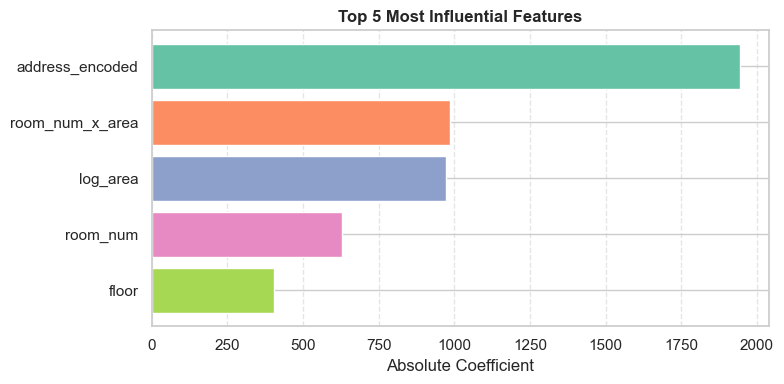

In [89]:
# תצוגת הפיצ'רים המשפיעים ביותר
importances = pd.Series(model.coef_, index=X.columns)
print("\nTop 5 Most Influential Features:")
print(importances.abs().sort_values(ascending=False).head(5))
top_features = importances.abs().sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 4))
bars = plt.barh(top_features.index, top_features.values, color=plt.cm.Set2(range(5)))
plt.title("Top 5 Most Influential Features", fontsize=12, fontweight='bold')
plt.xlabel("Absolute Coefficient", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<div dir="rtl">

1.`address_encoded` הפיצ’ר בעל ההשפעה הגבוהה ביותר על המחיר. הוא משקף את המיקום המדויק של הנכס ברזולוציה של רחוב, מה שמוסיף למודל יכולת להבין הבדלים דקים במחירי נכסים גם בתוך אותה שכונה. הקשר החזק מצביע על כך שמיקום מדויק (מעבר לרמת שכונה) הוא פקטור קריטי בתמחור.

2.`room_num_x_area` מכפלת מספר החדרים בשטח מייצגת את הגודל הכולל של הדירה באופן מורכב יותר. פיצ’ר זה נותן משקל גם לחלוקה הפנימית של הדירה ולא רק לשטח הכולל – דבר שמסייע לשפר את תחזית המחיר.

3.`log_area` טרנספורמציה לוגריתמית של שטח הדירה נועדה לטפל בהתפלגות לא נורמלית של ערכי שטח. השפעה גבוהה של פיצ'ר זה מעידה שהקשר בין שטח למחיר אינו ליניארי לחלוטין – תוספת שטח בדירות קטנות משפיעה יותר מאשר בדירות גדולות.

4.`room_num` מספר החדרים כשלעצמו משמש כאינדיקטור מרכזי לתמחור, במיוחד כשמדובר בייעוד של הדירה (יחיד, זוג, משפחה). משקף את השימושיות של הנכס בפועל.

5.`floor` הקומה בה נמצאת הדירה משפיעה על הערכת המחיר – בעיקר בערים כמו תל אביב שבהן גובה לעיתים מתקשר לנוף, שקט או פרטיות. הפיצ'ר תורם למודל להבין כיצד משתנה הערכת השווי בהתאם למיקום האנכי בבניין.

</div>


------------

# 📈 Random Forest Regression - ניתוח ובניית מודל


In [49]:
df = pd.read_csv('train.csv')  
df = prepare_data(df, 'train')
X = df.drop(columns=['price'])
y = df['price']

C:\Users\nitza\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [50]:
X_numeric = X.select_dtypes(include=[np.number]).copy()
X_scaled = StandardScaler().fit_transform(X_numeric)
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data.head(10)

C:\Users\nitza\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
19,luxury_score,inf
13,has_safe_room,inf
36,property_type_פנטהאוז,inf
35,property_type_סטודיו/לופט,inf
34,property_type_יחידת דיור,inf
33,property_type_דירת גן,inf
32,property_type_דירה,inf
31,property_type_דופלקס,inf
30,property_type_דו משפחתי,inf
14,has_balcony,inf


<div dir="rtl">

בפרויקט זה בחרנו לבצע אופטימיזציה של הפרמטרים באמצעות השיטה RandomizedSearchCV, וזאת בהתבסס על מאפייני הדאטה שלנו. הנתונים כוללים מעל 20 פיצ'רים מסוגים שונים (כמותיים, קטגוריים ובינאריים), והם מציגים טווחים רחבים של ערכים, מה שהופך את סריקת כל הקומבינציות האפשריות באמצעות GridSearchCV ליקרה מאוד מבחינת זמן חישוב ולרוב לא יעילה. לעומת זאת, RandomizedSearchCV מאפשר דגימה אקראית מתוך מרחב האפשרויות, ובכך מציע איזון מצוין בין מהירות לביצועים. הוא מאפשר להגיע לתוצאות טובות מאוד בפרק זמן סביר, במיוחד כאשר מספר ההיפר־פרמטרים או טווחיהם גבוהים, כפי שקיים במקרה שלנו. שיטה זו מתאימה במיוחד לפרויקטים שבהם הדאטה מגוונת, הגודל בינוני, והאופטימיזציה מתבצעת על מודלים עם מספר פרמטרים קריטיים כמו  RandomForest.

</div>


In [54]:
high_vif = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
# נגן על פיצ׳ר האיזור מכיוון שלמרות הדירוג הוא עדיין חזק ותורם לדיוק המודל
if 'area' in high_vif:
    high_vif.remove('area')
X = X.drop(columns=high_vif)
df = df.drop(columns=high_vif)
print("Features removed:", high_vif)

Features removed: ['luxury_score', 'has_safe_room', 'property_type_פנטהאוז', 'property_type_סטודיו/לופט', 'property_type_יחידת דיור', 'property_type_דירת גן', 'property_type_דירה', 'property_type_דופלקס', 'property_type_דו משפחתי', 'has_balcony', "property_type_פרטי/קוטג'", 'elevator', 'has_parking', 'room_num_x_area', 'log_area', 'room_num', 'area_x_monthly_arnona', 'monthly_arnona']


In [56]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include='object').columns.tolist()

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('power', PowerTransformer()),
    ('select', SelectKBest(score_func=f_regression, k='all'))
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

rf_base = RandomForestRegressor(random_state=42)

rf_transformed = TransformedTargetRegressor(
    regressor=rf_base,
    func=np.log1p,
    inverse_func=np.expm1
)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', rf_transformed)
])

In [57]:
param_dist = {
    'rf__regressor__n_estimators': randint(100, 600),
    'rf__regressor__max_depth': randint(5, 50),
    'rf__regressor__min_samples_split': randint(2, 10),
    'rf__regressor__min_samples_leaf': randint(1, 10),
    'rf__regressor__max_features': ['auto', 'sqrt', 0.3, 0.5, 0.7]
}
RandomForest_model = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=50, cv=10, scoring='neg_root_mean_squared_error',
                                   n_jobs=-1, random_state=42, verbose=1)
RandomForest_model.fit(X, y)
print("\nBest parameters from RandomizedSearchCV:")
print(RandomForest_model.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits

Best parameters from RandomizedSearchCV:
{'rf__regressor__max_depth': 28, 'rf__regressor__max_features': 0.7, 'rf__regressor__min_samples_leaf': 3, 'rf__regressor__min_samples_split': 5, 'rf__regressor__n_estimators': 459}


In [59]:
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(mean_squared_error, squared=False),
    'mae': 'neg_mean_absolute_error'}

rf_cv_results = cross_validate(RandomForest_model.best_estimator_, X, y, cv=10, scoring=scoring)
print("\n📊 Random Forest - 10 Fold CV Averages:")
print(f"🎯 R²: {np.mean(rf_cv_results['test_r2']):.4f}")
print(f"🎯 RMSE: ₪ {np.mean(rf_cv_results['test_rmse']):.2f}")
print(f"🎯 MAE: ₪ {np.mean(-rf_cv_results['test_mae']):.2f}")  


📊 Random Forest - 10 Fold CV Averages:
🎯 R²: 0.7734
🎯 RMSE: ₪ 1555.74
🎯 MAE: ₪ 1014.30


## The 5 features that have the biggest impact on price

                 feature  importance
19       address_encoded    0.600619
1                   area    0.229536
3           building_tax    0.043360
18  neighborhood_encoded    0.032454
12          room_density    0.024232


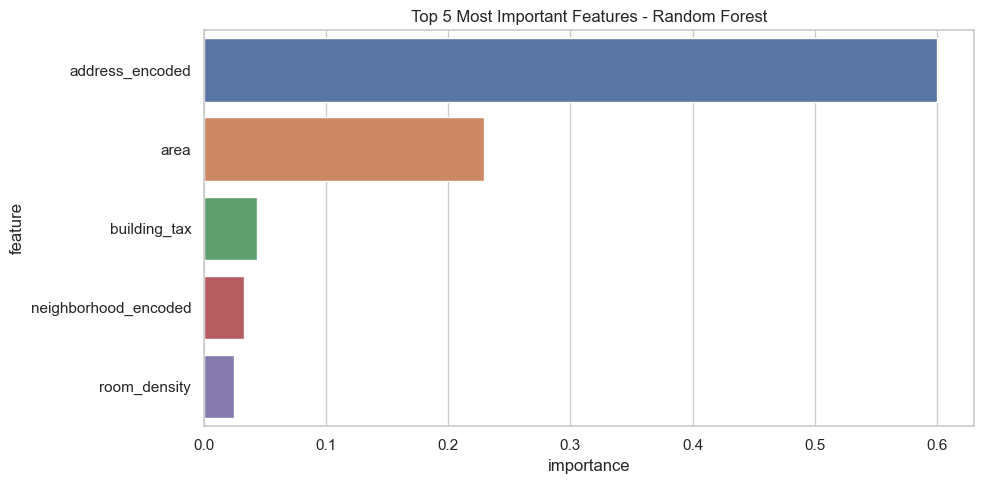

In [63]:
final_model = RandomForest_model.best_estimator_
feature_names = final_model.named_steps['prep'] \
    .transformers_[0][1] \
    .named_steps['power'] \
    .get_feature_names_out(num_features).tolist()

if cat_features:
    cat_names = final_model.named_steps['prep'] \
    .transformers_[1][1] \
    .named_steps['onehot'] \
    .get_feature_names_out(cat_features).tolist()
    feature_names += cat_names

rf_model_inside = final_model.named_steps['rf'].regressor_
importances = rf_model_inside.feature_importances_
importance_df = pd.DataFrame({'feature': feature_names,'importance': importances })
top_features = importance_df.sort_values('importance', ascending=False) 
print(top_features.head(5))

plt.figure(figsize=(10, 5))
sns.barplot(x='importance', y='feature', data=top_features.head(5))
plt.title("Top 5 Most Important Features - Random Forest")
plt.tight_layout()
plt.show()


<div dir="rtl">

1.`address_encoded` הפיצ'ר המשמעותי ביותר במודל Random Forest עם השפעה של יותר מ־60%. המשמעות היא שהמיקום המדויק של הדירה ברמת הרחוב משפיע בצורה קריטית על המחיר, הרבה מעבר לכל פיצ'ר אחר – אפילו שטח. זה מחזק את החשיבות של שימוש ב־Target Encoding לכתובת.

2.`area` שטח הדירה גם הוא מרכיב מרכזי בקביעת שווי הנכס, עם תרומה של כ־23%. מודלים מבוססי עצים מצליחים לנצל את הפיצ'ר הזה בצורה לא ליניארית, ומזהים הבדלים משמעותיים בין טווחי שטח שונים.

3.`building_tax` מס הבניין (לעיתים כולל ועד בית או תחזוקה) מהווה אינדיקציה לאיכות או יוקרת הבניין, תשתיות משותפות ומתקנים נוספים – ותרומתו היחסית מעידה שהמודל מזהה את הקשר בין תשלומים חודשיים גבוהים לבין ערך נדל”ני גבוה יותר.

4.`neighborhood_encoded` השכונה מקודדת לפי ממוצע מחירים וממשיכה לשחק תפקיד חשוב, אם כי פחות מהכתובת הספציפית. הפער בין השניים מדגיש שהשימוש ברחוב (address) נותן יכולת חיזוי טובה בהרבה מהשכונה בלבד.

5.`room_density` צפיפות חדרים לשטח (חדרים למ"ר) מספקת מדד עקיף לאיכות חיים. צפיפות נמוכה עשויה להעיד על דירה מרווחת ונוחה יותר – ולכן יקרה יותר. המודל מזהה גם את הפיצ’ר הזה כמשפיע, אם כי ברמה נמוכה יחסית לשאר.

</div>


-----

# ⚖️סיכום והשוואה בין המודלים

In [68]:
performance_data = {
    'Model': ['Elastic Net', 'Random Forest'],
    'R²': [en_r2, np.mean(rf_cv_results['test_r2'])],
    'RMSE': [en_rmse, np.mean(rf_cv_results['test_rmse'])],
    'MAE': [en_mae, np.mean(-rf_cv_results['test_mae'])]
}
pd.DataFrame(performance_data)

,Model,R²,RMSE,MAE
0,Elastic Net,0.799248,1553.629718,1062.262705
1,Random Forest,0.773403,1555.739247,1014.298538


<div dir="rtl">
    מהתוצאות ניתן לראות כי מודל Elastic Net השיג ביצועים מדויקים יותר כמעט בכל המדדים – עם R² גבוה יותר ו־RMSE נמוך יותר, מה שמעיד על יכולת חיזוי כללית עדיפה. עם זאת, מודל Random Forest הציג MAE נמוך יותר, כלומר טעות ממוצעת קטנה יותר למקרה בודד – מה שעשוי להעיד על יתרון בניבויים נקודתיים.

</div>


## 2. התאמה בין המאפיינים

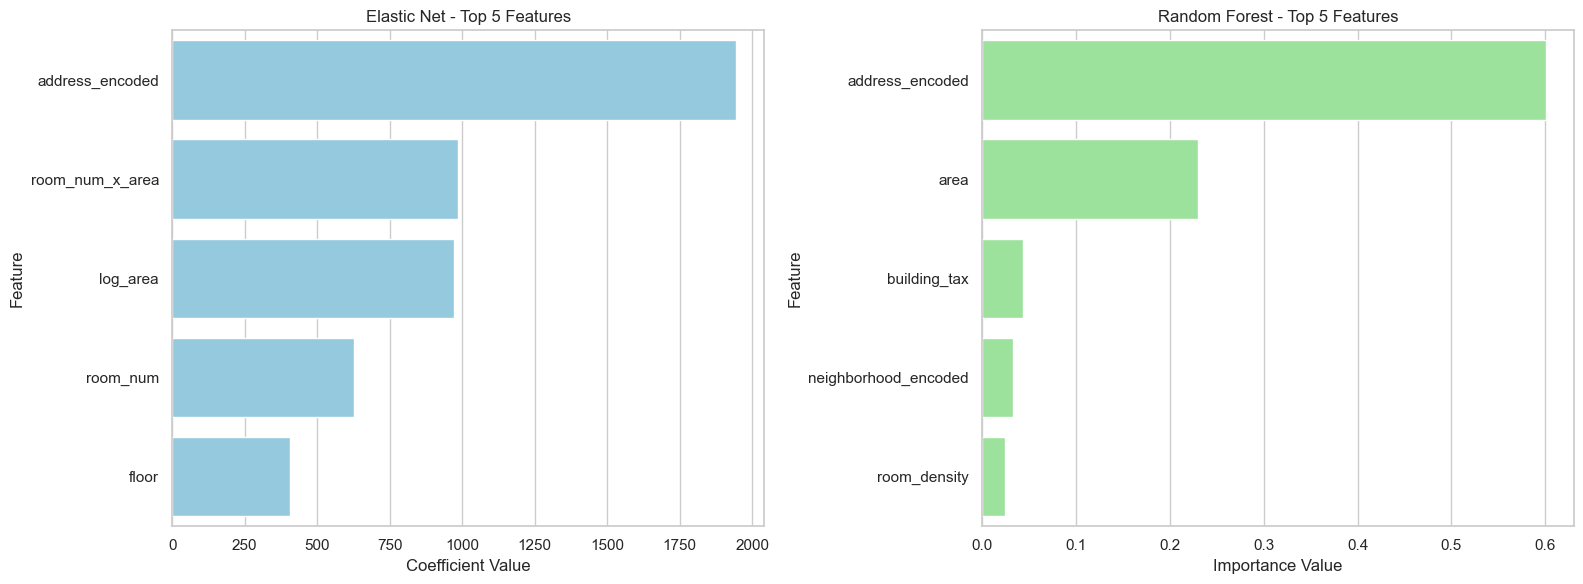

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Elastic Net
elastic_features = pd.DataFrame({
    'Feature': ['address_encoded', 'room_num_x_area', 'log_area', 'room_num', 'floor'],
    'Value': [1943.199946, 984.749179, 972.673781, 627.922615, 404.973060]
})
sns.barplot(ax=axes[0], data=elastic_features, x='Value', y='Feature', color='skyblue')
axes[0].set_title('Elastic Net - Top 5 Features')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')

# Random Forest
rf_features = pd.DataFrame({
    'Feature': ['address_encoded', 'area', 'building_tax', 'neighborhood_encoded', 'room_density'],
    'Value': [0.600619, 0.229536, 0.043360, 0.032454, 0.024232]
})
sns.barplot(ax=axes[1], data=rf_features, x='Value', y='Feature', color='lightgreen')
axes[1].set_title('Random Forest - Top 5 Features')
axes[1].set_xlabel('Importance Value')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

<div dir="rtl">

### ✅ נקודות משותפות בין המודלים:

1. **`address_encoded`** מופיע בפסגה של שני המודלים. המסקנה ברורה: מיקום מדויק ברמת הרחוב הוא הגורם המשמעותי והעקב ביותר בקביעת שווי הנכס – גם במודל ליניארי כמו ElasticNet וגם בעצי החלטה כמו Random Forest.

2. **`area`** (שטח הדירה) נחשב לפיצ’ר קריטי בשני המודלים, ומופיע במקום השני אצל Random Forest ובשלישייה הראשונה אצל ElasticNet. זהו מדד פיזי מובהק לערך כלכלי, שנשמר כמרכיב מרכזי גם במודלים מבוססי אינטראקציות.

---

### 🔍 השוני בין המודלים:

- **ElasticNet:**  
מתמקד בקשרים ליניאריים פשוטים וברורים. הוא נותן משקל גבוה ל:
  - **`room_num_x_area`** – אינטראקציה בין מספר חדרים לשטח.
  - **`log_area`** – טרנספורמציה שמטפלת בהתפלגות לא נורמלית.
  - **`room_num`** – מספר החדרים בפועל.
  - **`floor`** – גובה הקומה.  
  הפוקוס הוא על פיצ’רים שניתן לפרש בקלות – עם תרומה ישירה וברורה למחיר.

- **Random Forest:**  
שם דגש על משתנים פחות טריוויאליים ויותר מבניים:
  - **`building_tax`** – תשלומי תחזוקה כמדד ליוקרה.
  - **`neighborhood_encoded`** – קידוד של שכונות לפי מחיר ממוצע.
  - **`room_density`** – צפיפות חדרים לשטח, כמדד עקיף לאיכות חיים.  
  המודל מזהה קשרים לא ליניאריים, אינטראקציות מרובות ואינו תלוי בקשר ישיר בין פיצ’ר לתוצאה.

---

### 🧠 מסקנה:

למרות שהמודלים שונים במהותם, שניהם מדגישים את חשיבות המיקום והשטח, ומתחלקים בגישות שונות להבנת יתר הגורמים – בין אם דרך משוואה ליניארית או באמצעות זיהוי תבניות חבויות בעצים.

</div>


## 3. הבדלים בין המודלים וסיכום

<div dir="rtl">

- **ElasticNet** הוא מודל ליניארי רגולרי, המשלב בין רגרסיית Ridge ו־Lasso. הוא מועדף כאשר נדרש להבין את תרומת כל פיצ’ר בצורה שקופה וברורה.  
  במדדי הביצוע שהתקבלו:
  - R²: **0.799** – כלומר המודל מסביר כ־79.9% מהשונות במחירים.
  - RMSE: **₪1,553** – טעות ממוצעת ריבועית נמוכה מאוד למודל ליניארי.
  - MAE: **₪1,062** – טעות מוחלטת ממוצעת מתונה אך טובה מאוד.

  המודל מצליח להשיג ביצועים מדויקים, למרות הפשטות והמבנה הליניארי. זה מצביע על כך שהקשרים המרכזיים בין הפיצ’רים למחיר הם במידה רבה ישירים וברורים.

---

- **Random Forest** הוא מודל מבוסס עצי החלטה, שיודע לזהות קשרים לא ליניאריים ואינטראקציות מורכבות בין משתנים – גם מבלי הנחות מוקדמות.  
  במדדי הביצוע:
  - R²: **0.773** – המודל מסביר כ־77.3% מהשונות במחירים (פחות מ־ElasticNet).
  - RMSE: **₪1,556** – טעות ריבועית מעט גבוהה יותר.
  - MAE: **₪1,014** – טעות מוחלטת ממוצעת הנמוכה ביותר מבין השניים.

  המודל מצליח למצות ערך נוסף מפיצ’רים מהונדסים עם קשרים לא ישירים, כמו `room_density`, מה שמעניק לו יתרון מסוים בדיוק תחזיתי עבור מקרים בודדים.

---

### 🧠 מסקנה עיקרית:
- **ElasticNet** מצטיין בהסבריות, דיוק כולל (R² ו־RMSE), ופשטות – אידיאלי למקרים בהם השקיפות והשליטה חשובים.
- **Random Forest** מפיק את השגיאה המוחלטת הנמוכה ביותר (MAE), כלומר מדויק יותר עבור תחזיות נקודתיות – אך פחות ברור לפרשנות.

:לכן, הבחירה בין המודלים תלויה בשאלה:
- האם אתה צריך **דיוק תחזיתי כללי ומודלים מוסברים היטב**? → ElasticNet  
- האם אתה צריך **תחזיות מדויקות ברמת העסקה הבודדת**? → Random Forest

</div>
